## 기본 세팅

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imagehash > /dev/null

In [ ]:
# path 설정
filepath = '/content/drive/MyDrive/Project II/pet_data/'
modelpath = '/content/drive/MyDrive/Project II/model/'
train_path = filepath + 'train/'
cat_path = train_path + 'cat/'
dog_path = train_path + 'dog/'

In [ ]:
# 모듈 import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from glob import glob
import sys
import cv2
import imageio
import joblib
import math
import warnings
import os
import torch
import imagehash
import matplotlib.patches as patches
from tqdm import tqdm
# cnn 예측 모델 사용
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import tensorflow as tf

# 강아지 얼굴 인식
# import cv2
import dlib
from imutils import face_utils

In [ ]:
%matplotlib inline

### YOLOv5 model

 - 아래 내용은 [캐글 참고](https://www.kaggle.com/markwijkhuizen/petfinder-eda-yolov5-obj-detection-tfrecords)
 에서 가져왔음

In [ ]:
# Download YOLOV5 GitHub Repo
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9758, done.
remote: Total 9758 (delta 0), reused 0 (delta 0), pack-reused 9758
Receiving objects: 100% (9758/9758), 10.10 MiB | 25.29 MiB/s, done.
Resolving deltas: 100% (6775/6775), done.


In [ ]:
# Load Best Performing YOLOV5X Model
yolov5x6_model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-10-27 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)



  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



  0%|          | 0.00/269M [00:00<?, ?B/s]

Fusing layers... 
Model Summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


- 이미지 분석 함수 YOLOv5를 사용하고 있고 캐글에서 만든 함수를 수정하여 사용중

### dogHeadDetector 모델

In [ ]:
# GPU 런타임 필요 https://realist.tistory.com/m/11
# reason: no CUDA-capable device is detected 오류 발생시 런타임 설정을 None -> GPU로 설정
detector = dlib.cnn_face_detection_model_v1(modelpath + 'dogHeadDetector.dat')
# predictor = dlib.shape_predictor(modelpath + 'landmarkDetector.dat') 강아지 얼굴에서 랜드마크(귀 눈 코 와 같은 부분을 점으로 찍어주는 모델)

## FUNCTION

### detecte_dog_faces
- 강아지의 얼굴의 위치를 찾아내는 함수
- input : img => cv2.imread(file_path) cv2.imread로 읽어온 이미지
- output : dets => rectangle 형태로 left, top, bottom, right로 접근 가능 강아지 얼굴이 있는 사각형의 왼쪽 위, 오른쪽 아래 좌표

In [ ]:
def detecte_dog_faces(img):
  # detector를 통해 얼굴을 찾아옴
  dets = detector(img, upsample_num_times=1) 

  img_result = img.copy()

  # 강아지 얼굴에 빨간 네모로 표시
  for i, d in enumerate(dets):
      
      # print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))

      x1, y1 = d.rect.left(), d.rect.top()
      x2, y2 = d.rect.right(), d.rect.bottom()

      cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
  
  # 그래프
  plt.figure(figsize=(8, 8))
  plt.imshow(img_result)

  return dets

### get_image_info
- 입력된 이미지에서 정보를 추출하여 image_info 객체에 저장하는 함수
- input : file_path => 이미지 저장 주소
- input : plot=False => 인식된 객체에 네모그림 그릴 여부를 지정
- output : image_info 객체

In [ ]:
# Get Image Info
def get_image_info(file_path, plot=False):
    # Read Image
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, c = image.shape
    
    # 그래프
    if plot: # Debug Plots
        fig, ax = plt.subplots(1, 2, figsize=(8,8))
        ax[0].set_title('Pets detected in Image', size=16)
        ax[0].imshow(image)
        
    # Get YOLOV5 results using Test Time Augmentation for better result
    results = yolov5x6_model(image, augment=True)
    
    # Mask for pixels containing pets, initially all set to zero
    pet_pixels = np.zeros(shape=[h, w], dtype=np.uint8)
    
    # Dictionary to Save Image Info
    h, w, _ = image.shape # 높이, 너비, 차원
    image_info = { 
        'name': '', # 입력된 파일 이름
        'n_pets': 0, # Number of pets in the image
        'labels': [], # Label assigned to found objects 
        'human' : 0, # 사람의 신체부위나 사람이 나타나는 경우
        'face' : 0, # 얼굴이 정면을 조금이라도 보고있으면 (사진에 2개의 동공이 잡히는 경우 1)
        'thresholds': [], # confidence score
        'coords': [], # coordinates of bounding boxes
        'face_rects': [], # 동물 얼굴의 범위
        'x_min': 0, # minimum x coordinate of pet bounding box
        'x_max': w - 1, # maximum x coordinate of pet bounding box
        'y_min': 0, # minimum y coordinate of pet bounding box
        'y_max': h - 1, # maximum x coordinate of pet bounding box
    }
    
    image_info['name'] = file_path.split('/')[-1][:-4]

    # 강아지 얼굴을 찾는 함수
    dets = detecte_dog_faces(image)
    if dets:
      image_info['face'] = 1
      # print(f'dets = {dets}')
      for d in dets:
        image_info['face_rects'].append(tuple([d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()]))


    # Save found pets to draw bounding boxes
    pets_found = []
    
    # Save info for each pet
    for x1, y1, x2, y2, treshold, label in results.xyxy[0].cpu().detach().numpy():
        label = results.names[int(label)]
        # print(f'label : {label}')
        
        # image_info 저장
        if label in ['cat', 'dog']:
          image_info['n_pets'] += 1
          # Set pixels containing pets to 1
          pet_pixels[int(y1):int(y2), int(x1):int(x2)] = 1 # label이 cat, dog인 경우만 pet의 범위로 지정

        if label in ['Human']: # 사람의 신체부위가 나타나는 경우
          image_info['Human'] += 1

        image_info['labels'].append(label)
        image_info['thresholds'].append(treshold)
        image_info['coords'].append(tuple([x1, y1, x2, y2]))
        image_info['x_min'] = max(x1, image_info['x_min'])
        image_info['x_max'] = min(x2, image_info['x_max'])
        image_info['y_min'] = max(y1, image_info['y_min'])
        image_info['y_max'] = min(y2, image_info['y_max'])
            

        # Add found pet
        pets_found.append([x1, x2, y1, y2, label])

    # 그래프
    if plot:
        for x1, x2, y1, y2, label in pets_found:
            c = 'red' if label == 'dog' else 'blue'
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=c, facecolor='none')
            # Add the patch to the Axes
            ax[0].add_patch(rect)
            ax[0].text(max(25, (x2+x1)/2), max(25, y1-h*0.02), label, c=c, ha='center', size=14)
                
    # Add Pet Ratio in Image
    # print(f'pet_ratio : {pet_pixels.sum() / (h*w)}')
    image_info['pet_ratio'] = pet_pixels.sum() / (h*w)

    if plot:
        # Show pet pixels
        ax[1].set_title('Pixels Containing Pets', size=16)
        ax[1].imshow(pet_pixels)
        plt.show()
        
    return image_info

### print_info
- 입력된 image의 정보를 출력하는 함수
- input : img_info => get_image_info 에서 만들어진 image_info 객체
- output : NONE, 프린트 문

In [ ]:
# image 정보를 출력하는 함수.. 

def print_info(img_info):
  print('-'*5)
  print(f'''
  {img_info['name']}에는 {img_info['n_pets']}마리의 반려동물이 있습니다.
  {str(img_info['human']) +'명의 사람이 있으며' if img_info['human'] > 0 else '사람의 모습은 보이지 않으며'}
  동물이 차지하는 범위는 약 {np.round(img_info['pet_ratio'], 2) * 100}%입니다.
  이 동물의 얼굴은 { '잘 보이며' if img_info['face'] == 1 else '안 보이며'}
  아주 귀엽습니다.  
  ''')
  print('-'*5)

### upscale_img
- 이미지의 화질을 개선하는 함수
- input : img_path => 이미지 저장 위치
- output : cv2.imread로 읽어낸 image


In [ ]:
import requests, urllib.request
import json

def upscale_img(img_path):
  r = requests.post(
      "https://api.deepai.org/api/waifu2x",
      files={
          'image':open(img_path, 'rb'),
      },
      headers={'api-key': '0b69b258-6717-4a58-af68-4a8654c9c78f'}
  )
  d = r.json()
  # print(d)
  url = d['output_url']

  urllib.request.urlretrieve(url, "test.jpg") # url을 통해 jpg파일로 저장

  # 저장 된 이미지 확인
  img = cv2.imread("test.jpg")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

### saturate_contrast
- 이미지의 대비값을 조정하는 함수
- input : img => cv2.imread()로 읽어낸 이미지
- input : num => 대비 비율 조정할 상수값
- output : 조정된 image

In [ ]:
def saturate_contrast(img, num):
  pic = img.copy()
  pic = pic.astype('int32')
  pic = np.clip(pic + (pic-128) * num, 0, 255) # 최소 0 ~ 255의 값만 존재하게됨
  pic = pic.astype('int32')
  return pic

### light_contrast
- 이미지의 밝기값을 조정하는 함수
- input : img => cv2.imread()로 읽어낸 이미지
- input : num => 밝기 비율 조정할 상수값
- output : 조정된 image

In [ ]:
def light_contrast(img, num):
  pic = img.copy()
  pic = pic.astype('int32')
  pic = np.clip(pic + num, 0, 255) # 최소 0 ~ 255의 값만 존재하게됨
  pic = pic.astype('int32')
  return pic

### contrast
- 이미지의 밝기값과 대비를 일정값으로 조정하는 함수
- input : img => cv2.imread()로 읽어낸 이미지
- output : 조정된 image

In [ ]:
# 일정값으로 한번에 대비 밝기 조절
def contrast(img):
  pic = img.copy()
  pic = pic.astype('int32')
  
  pic = upscale_img(img_path)
  pic = saturate_contrast(pic, 0.5)
  pic = light_contrast(pic, 50)

  pic = pic.astype('int32')
  return pic

### draw_image
- 이미지 2개 비교해서 그리는 함수
- input : img1 => 기본적으로 original image
- input : img2 => 기본적으로 보정된 image

In [ ]:
def draw_image(img1, img2):
  fig = plt.figure(figsize=(12, 12))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.imshow(img1)
  ax1.set_title('before')
  ax1.axis("off")

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.imshow(img2)
  ax2.set_title('after')
  ax2.axis("off")

  plt.show()

### preprocess
- 준수님이 작성해주신 CNN에 사용할 이미지 데이터 전처리 함수

In [ ]:
image_size = 128

# 이미지 크기 128 x 128로 변환
# JPEG로 인코딩 된 이미지를 uint8 텐서로 디코딩
# 255로 나누어 픽셀값 정규화 

def preprocess(image_url):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (image_size, image_size))
    return image

## 실행 예제

### 이미지에서 정보 추출 후 출력하기

-----

  dog140에는 1마리의 반려동물이 있습니다.
  사람의 모습은 보이지 않으며
  동물이 차지하는 범위는 약 34.0%입니다.
  이 동물의 얼굴은 잘 보이며
  아주 귀엽습니다.  
  
-----


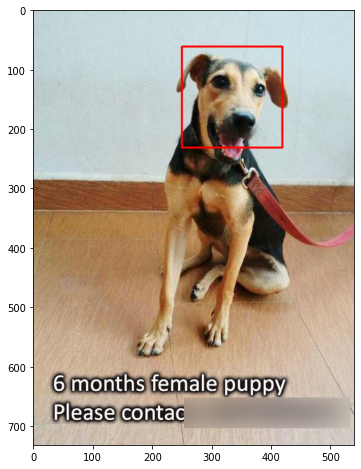

In [ ]:
img_path = dog_path + 'dog140.jpg'
print_info(get_image_info(img_path))

### 화질 개선 전 후 비교 출력하기

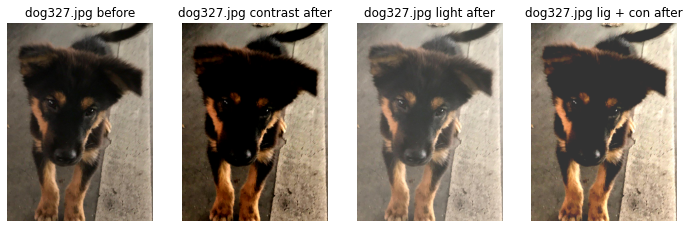

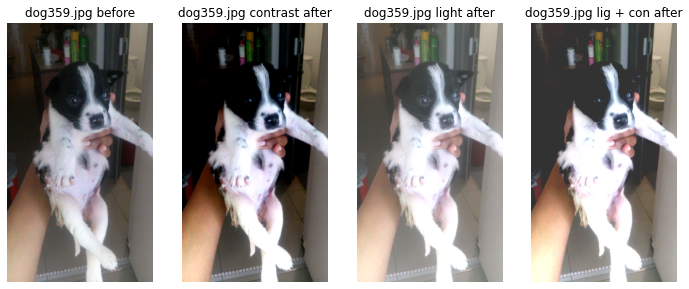

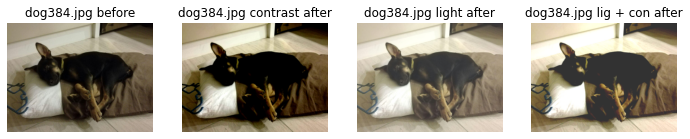

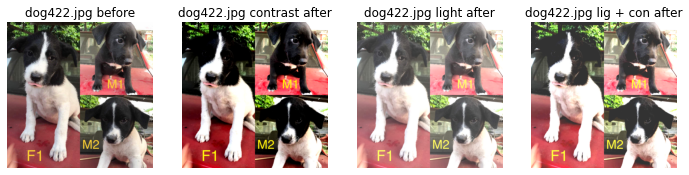

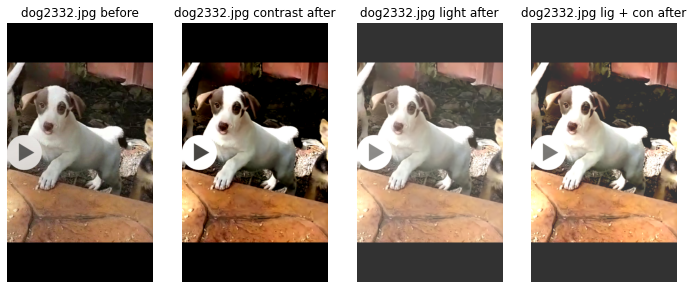

In [ ]:
# 화질 개선 전 후 비교 하는 출력
# 327, 359, 384
d_list = ['dog327.jpg', 'dog359.jpg', 'dog384.jpg', 'dog422.jpg', 'dog2332.jpg']

for f in d_list:
  img_path = dog_path + f
  img = cv2.imread(dog_path + f)
  fig = plt.figure(figsize=(12, 12))

  ax1 = fig.add_subplot(1, 4, 1)
  ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax1.set_title(f + ' before')
  ax1.axis("off")

  up_img = upscale_img(img_path)
  # cv2.imwrite(filepath + 'up_' + f, img)

  n_img = saturate_contrast(up_img, 0.5)
  cv2.imwrite(filepath + 'con_' + f, img)

  ax2 = fig.add_subplot(1, 4, 2)
  ax2.imshow(n_img)
  ax2.set_title(f + ' contrast after')
  ax2.axis("off")
  
  n2_img = light_contrast(up_img, 50)
  cv2.imwrite(filepath + 'lig_' + f, img)

  ax3 = fig.add_subplot(1, 4, 3)
  ax3.imshow(n2_img)
  ax3.set_title(f + ' light after')
  ax3.axis("off")

  n2_img = light_contrast(n_img, 50)
  cv2.imwrite(filepath + 'all_' + f, img)

  ax3 = fig.add_subplot(1, 4, 4)
  ax3.imshow(n2_img)
  ax3.set_title(f + ' lig + con after')
  ax3.axis("off")

  plt.show()

### 이미지 업로드 후 수정하여 예측 모델 돌려보기

-----

  dog33에는 3마리의 반려동물이 있습니다.
  사람의 모습은 보이지 않으며
  동물이 차지하는 범위는 약 67.0%입니다.
  이 동물의 얼굴은 잘 보이며
  아주 귀엽습니다.  
  
-----


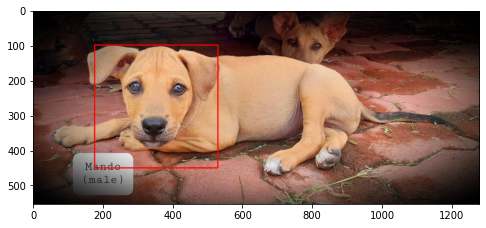

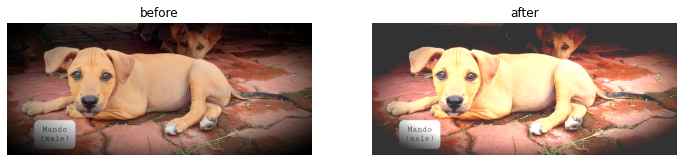

In [ ]:
img_path = dog_path + 'dog33.jpg' # 이미지 주소
img = cv2.imread(img_path) #cv2.imread로 읽어오기
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2.imread 를 하게되면 rgb의 순서가 bgr로 되어있으므로 바꾸어 주어야 함. 이 함수를 실행하지 않으면 파란색 동물이 나옴..

print_info(get_image_info(img_path)) # 이미지 정보 출력

new_img = contrast(img) # 색상, 대비, 화질개선

draw_image(img, new_img) # 두개의 사진 비교

In [ ]:
# cv2.imwrite(filepath + filename, img) 을 통해서 만들어진 이미지를 저장 할 수 있음
cv2.imwrite('original.jpg', img)
cv2.imwrite('new.jpg', new_img)

True

In [ ]:
# CNN 예측을 위해 전처리
original_list = ['original.jpg']
new_list = ['new.jpg']

In [ ]:
# 기존 사진리스트 전처리
origin = []
for i in original_list:
    x1=preprocess(i)
    origin.append(x1)
origin=np.array(origin)

In [ ]:
# 새로운 사진리스트 전처리
new = []
for i in new_list:
    x1=preprocess(i)
    new.append(x1)
new=np.array(new)

In [ ]:
# 모델 로드
reconstructed_model = keras.models.load_model(modelpath + "cnn_predict.h5")

In [ ]:
original_pred = reconstructed_model.predict(origin)
original_pred

array([[     33.208]], dtype=float32)

In [ ]:
new_pred = reconstructed_model.predict(new)
new_pred

array([[     34.899]], dtype=float32)